In [83]:
import pandas, numpy, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

In [3]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [24]:
%%time
# DL data ATG7 isoform expression
path = input_file_directory + "/mef_jc10/exp1/no_shake"
red_path = '/jc10_exp1_red_noshake.csv'
green_path = '/jc10_exp1_green_noshake.csv'

df_aggregates= pandas.read_csv(path+red_path, sep = ";")
df_aggregates = df_aggregates.apply(lambda x: x.str.replace(',','.'))


df_monomeric= pandas.read_csv(path+green_path, sep = ";")
df_monomeric = df_monomeric.apply(lambda x: x.str.replace(',','.'))

print(df_aggregates)

Wall time: 11 ms


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
2,DMSO,19.809,18.859,19.041,18.674,17.925,19.336,18.632
3,DMSO+FCCP,19.207,18.252,18.314,18.517,17.713,19.138,19.215
4,DMSO+FCCP,18.998,17.79,17.66,18.02,17.509,18.233,17.636
5,DMSO+FCCP,17.537,18.941,18.586,21.497,16.133,17.694,17.886
6,BAF,20.032,19.209,20.242,19.806,20.446,20.374,19.796
7,BAF+FCCP,19.536,18.373,18.727,19.005,18.377,19.161,19.648
8,BAF+FCCP,18.341,17.86,18.967,19.282,18.942,19.559,18.964
9,BAF+FCCP,19.576,18.333,19.149,19.151,19.695,19.446,19.722


In [25]:
dfs = df_aggregates, df_monomeric
for df in dfs:
    #select column name and index label
    df.columns = df.iloc[1]
    df.columns.name = None 
    #drop the first useless rows + dmso/baf, positive control for FCCP
    df.drop(df.index[0:3], inplace = True)
    df.drop(df.index[3], inplace = True)
    #reset index
    df.reset_index(drop = True, inplace = True)

#to numeric
df_monomeric.iloc[:,1:8] = df_monomeric.iloc[:,1:8].apply(pandas.to_numeric, errors='coerce', axis=1)
df_aggregates.iloc[:,1:8] = df_aggregates.iloc[:,1:8].apply(pandas.to_numeric, errors='coerce', axis=1)
df_aggregates

,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
0,DMSO+FCCP,19.207,18.252,18.314,18.517,17.713,19.138,19.215
1,DMSO+FCCP,18.998,17.79,17.66,18.02,17.509,18.233,17.636
2,DMSO+FCCP,17.537,18.941,18.586,21.497,16.133,17.694,17.886
3,BAF+FCCP,19.536,18.373,18.727,19.005,18.377,19.161,19.648
4,BAF+FCCP,18.341,17.86,18.967,19.282,18.942,19.559,18.964
5,BAF+FCCP,19.576,18.333,19.149,19.151,19.695,19.446,19.722


In [28]:
#create dataframe for ratio
df_ratio = df_aggregates.copy()
df_ratio.drop(df_ratio.columns[1:], axis = 1, inplace = True)
df_ratio = df_ratio.assign(condition = df_monomeric['condition'],
                           normal= df_monomeric['normal'] / df_aggregates['normal'],
                           ev= df_monomeric['ev'] / df_aggregates['ev'],
                           ev_dox= df_monomeric['ev_dox'] / df_aggregates['ev_dox'],
                           wt1= df_monomeric['wt1'] / df_aggregates['wt1'],
                           vsr1= df_monomeric['vsr1'] / df_aggregates['vsr1'],
                           wt2= df_monomeric['wt2'] / df_aggregates['wt2'],
                           vsr2= df_monomeric['vsr2'] / df_aggregates['vsr2'])
df_ratio

,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
0,DMSO_FCCP,2.02582,2.01512,2.26253,2.19301,2.21933,2.36038,2.22399
1,DMSO_FCCP,1.95663,1.88398,2.17752,2.21565,1.96122,2.18488,2.15701
2,DMSO_FCCP,1.61333,1.72953,1.85328,1.83942,1.83506,1.82599,1.96299
3,BAF_FCCP,2.5281,2.35955,2.56726,2.61347,2.62486,2.97458,2.7925
4,BAF_FCCP,2.61632,2.46948,2.59704,2.55212,2.53622,2.87366,2.6883
5,BAF_FCCP,2.46404,2.33421,2.34383,2.38593,2.24986,2.44256,2.60932


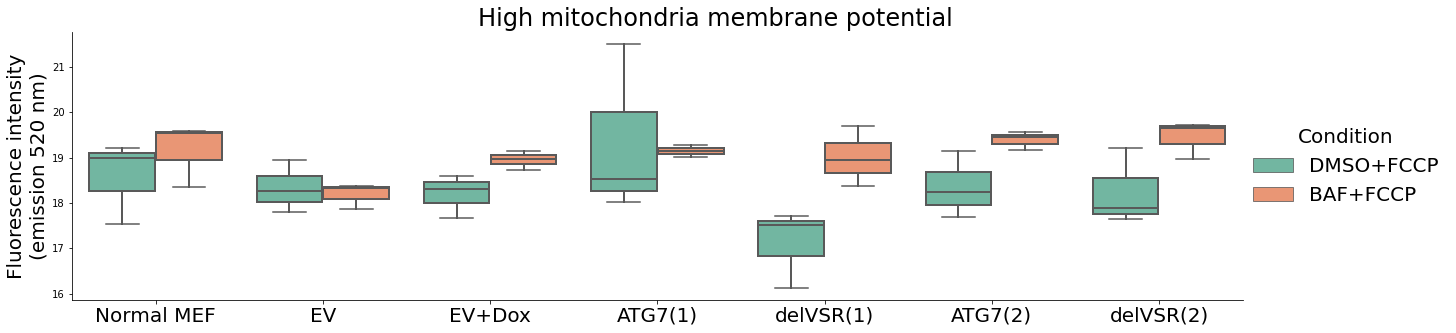

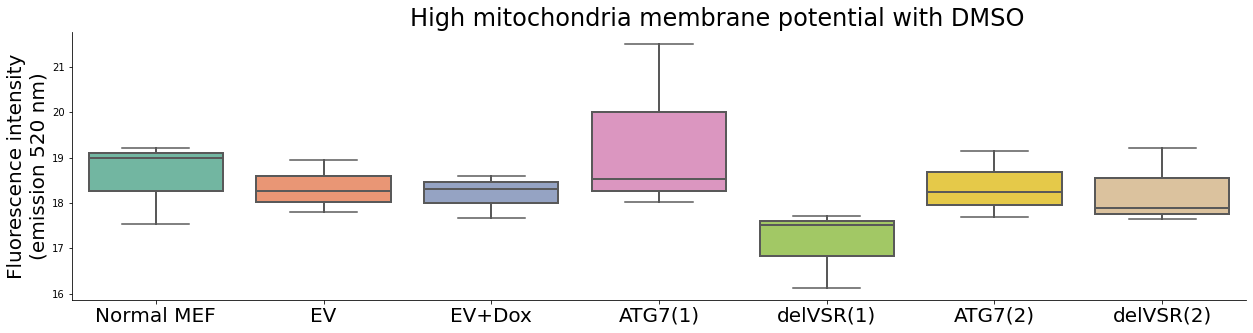

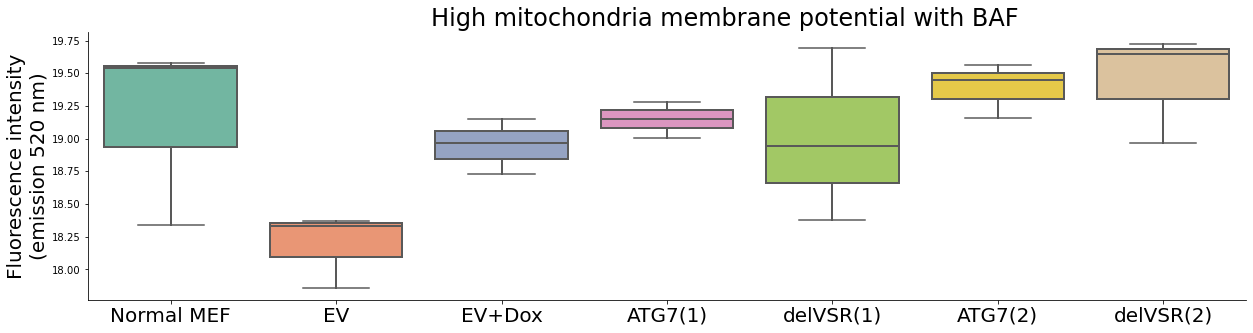

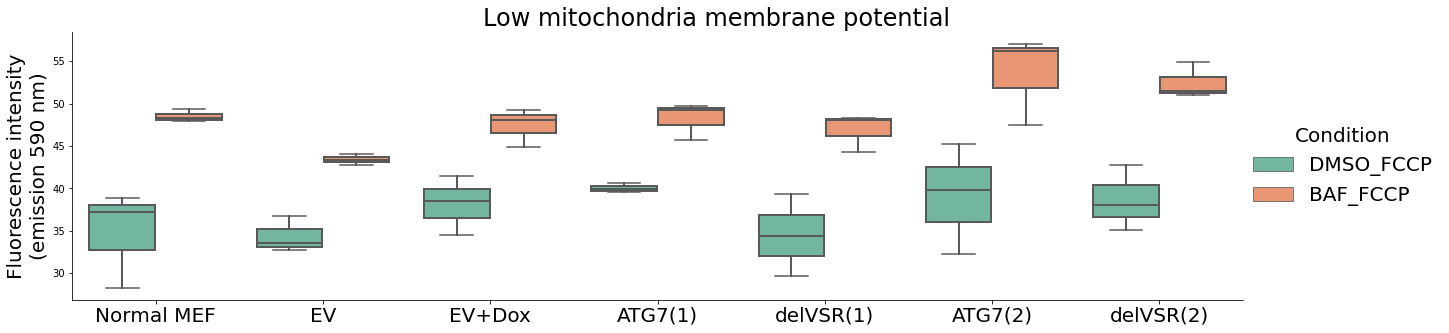

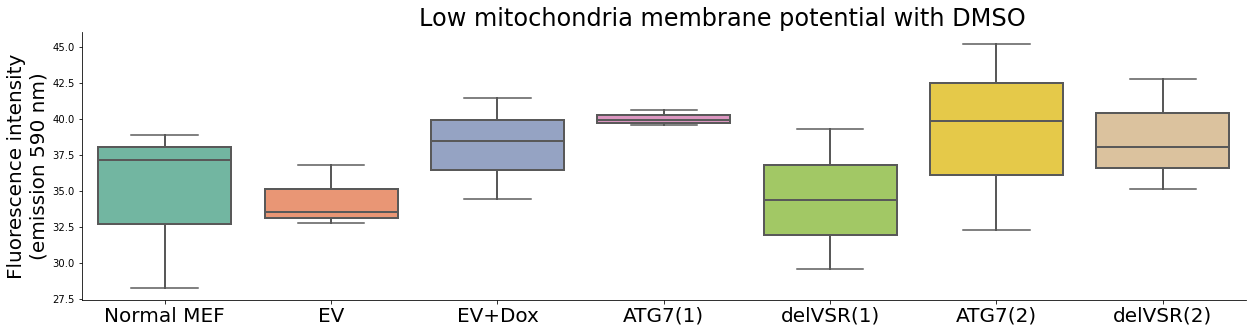

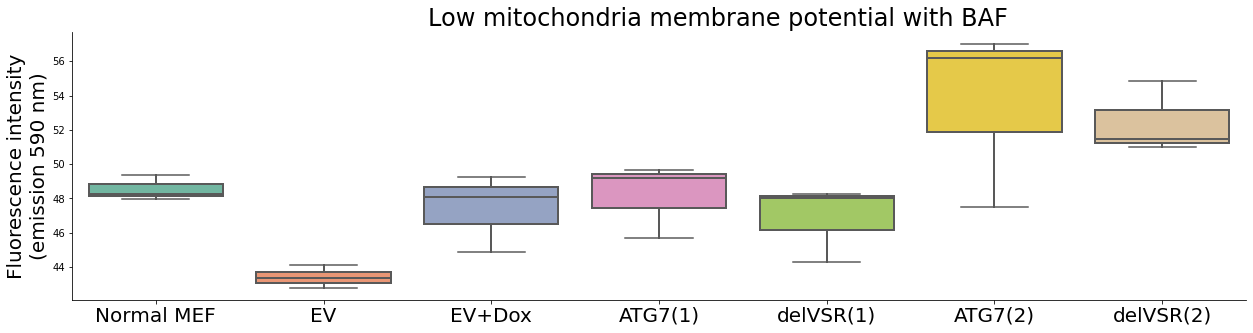

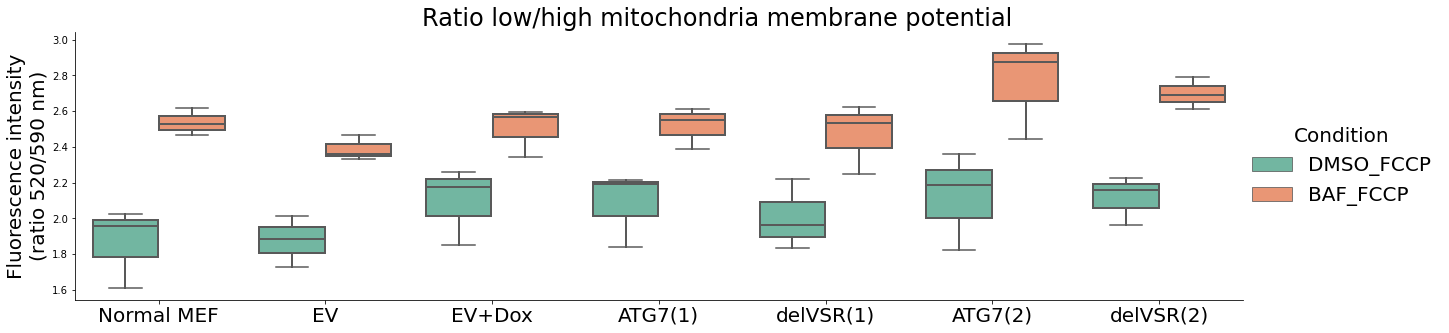

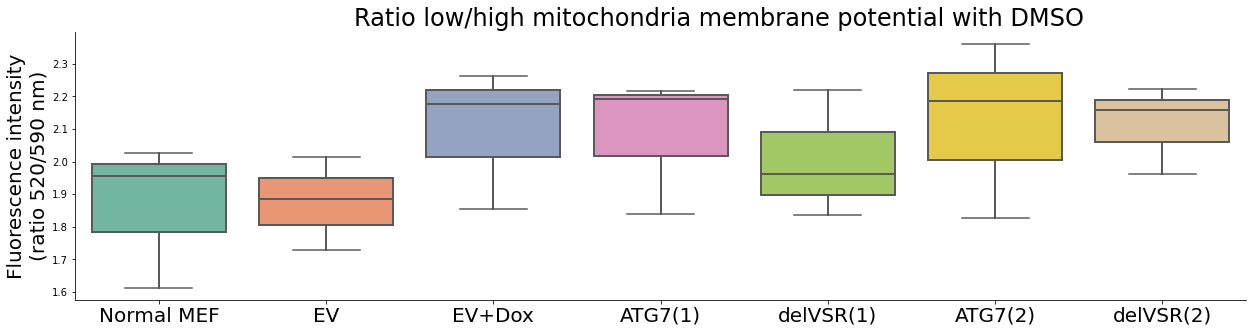

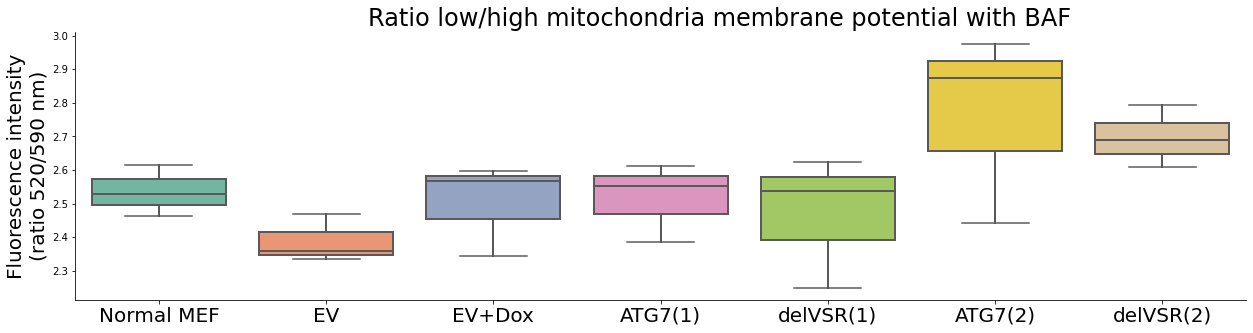

In [88]:
# Distribution: Data preparation + graph
all_data = [[df_aggregates, 'High mitochondria membrane potential', '(emission 520 nm)'],
             [df_monomeric, 'Low mitochondria membrane potential', '(emission 590 nm)'],
             [df_ratio, 'Ratio low/high mitochondria membrane potential', '(ratio 520/590 nm)']]

for data_ in all_data:
    Data = data_[0]
    info = data_[1]
    info_fluo = data_[2]
    
    shape = Data.shape
    shape = shape[0]
#     print(shape)

    #select the sample type column
    media_condition = {'condition':[Data.iloc[:,0][i]
      for i in range(0, shape)]}

    #convert to df, and copy it 3 times
    media_conditiondf = pandas.DataFrame(media_condition)
    media_conditiondf = pandas.concat([media_conditiondf,media_conditiondf,media_conditiondf,
                                      media_conditiondf,media_conditiondf,media_conditiondf,
                                      media_conditiondf])

    media_conditiondf.reset_index(drop=True, inplace=True)

    # Y for expression value 
    y = {'y':[Data.iloc[:,j][i]
      for j in range(1,8)
        for i in range(0, shape)]}

    #create df with Y 
    data_distrib = pandas.DataFrame(y).astype(float)

    # X for ATG7/iso1/iso2                              
    data_distrib.loc[:shape,'x'] = 'Normal MEF'
    data_distrib.loc[shape: shape*2,'x'] = 'EV'
    data_distrib.loc[shape*2: shape*3,'x'] = 'EV+Dox'
    data_distrib.loc[shape*3: shape*4,'x'] = 'ATG7(1)'
    data_distrib.loc[shape*4: shape*5,'x'] = 'delVSR(1)'
    data_distrib.loc[shape*5: shape*6,'x'] = 'ATG7(2)'
    data_distrib.loc[shape*6:,'x'] = 'delVSR(2)'

    # Will be used for Hue
    data_distrib['Condition'] = media_conditiondf['condition']
    
    #graph to see BAF + DMSO in the same graph. Useful to see BAF effect
    seaborn.catplot(x="x", y="y", hue="Condition", aspect = 3.5, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

    plt.ylabel('Fluorescence intensity\n' + info_fluo)
    plt.xlabel('')
    plt.title(info, x=.55)
    print()

    #separation of DMSO and BAF
    df_dmso = data_distrib[data_distrib['Condition'].str.startswith('DMSO')]
    df2_baf = data_distrib[data_distrib['Condition'].str.startswith('BAF')]
    
    dfs_conditions = [[df_dmso, ' with DMSO'], [df2_baf, ' with BAF']]
    for df_ in dfs_conditions:
        data_drug = df_[0]
        drug_info = df_[1]
    
        #graph with BAF or DMSO treatment separatly to have a better view of the cell lines
        seaborn.catplot(x="x", y="y", aspect = 3.5, kind="box", palette = 'Set2', data = data_drug,
                        boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

        plt.ylabel('Fluorescence intensity\n' + info_fluo)
        plt.xlabel('')
        plt.title(info+drug_info, x=.55)
        print()

# print()


In [112]:
#Distribution: Stats for all 
all_data = [[df_ratio, 'Ratio low/high mitochondria membrane potential', '(ratio 520/590 nm)']]

column_name = df_aggregates.keys()
for data_ in all_data:
    Data = data_[0]
    info = data_[1]
    info_fluo = data_[2]  
    print(info)
    
    #separation of DMSO and BAF
    df_dmso = Data[Data['condition'].str.startswith('DMSO')]
    df2_baf = Data[Data['condition'].str.startswith('BAF')]

    dfs_conditions = [[df_dmso, 'with DMSO'], [df2_baf, 'with BAF']]
    for df_ in dfs_conditions:
        data_drug = df_[0]
        drug_info = df_[1]
        print(drug_info.upper())
        
        # Mann-Whitney analysis 
        #EV vs WT1
        statistic, pvalue = scipy.stats.mannwhitneyu(data_drug[column_name[3]], data_drug[column_name[4]])
        Pvalue = "{:.3E}".format(pvalue)
        print(column_name[3], "and", column_name[4], drug_info, 'pvalue is', Pvalue)
        
        #EV vs WT1
        statistic, pvalue = scipy.stats.mannwhitneyu(data_drug[column_name[3]], data_drug[column_name[6]])
        Pvalue = "{:.3E}".format(pvalue)
        print(column_name[3], "and", column_name[6], drug_info, 'pvalue is', Pvalue)
        
         #EV vs WT1
        statistic, pvalue = scipy.stats.mannwhitneyu(data_drug[column_name[4]], data_drug[column_name[6]])
        Pvalue = "{:.3E}".format(pvalue)
        print(column_name[4], "and", column_name[6], drug_info, 'pvalue is', Pvalue)
        print()

Ratio low/high mitochondria membrane potential
WITH DMSO
ev_dox and wt1 with DMSO pvalue is 5.000E-01
ev_dox and wt2 with DMSO pvalue is 5.000E-01
wt1 and wt2 with DMSO pvalue is 5.000E-01

WITH BAF
ev_dox and wt1 with BAF pvalue is 5.000E-01
ev_dox and wt2 with BAF pvalue is 1.914E-01
wt1 and wt2 with BAF pvalue is 1.914E-01



In [113]:
Data

,condition,normal,ev,ev_dox,wt1,vsr1,wt2,vsr2
0,DMSO_FCCP,2.02582,2.01512,2.26253,2.19301,2.21933,2.36038,2.22399
1,DMSO_FCCP,1.95663,1.88398,2.17752,2.21565,1.96122,2.18488,2.15701
2,DMSO_FCCP,1.61333,1.72953,1.85328,1.83942,1.83506,1.82599,1.96299
3,BAF_FCCP,2.5281,2.35955,2.56726,2.61347,2.62486,2.97458,2.7925
4,BAF_FCCP,2.61632,2.46948,2.59704,2.55212,2.53622,2.87366,2.6883
5,BAF_FCCP,2.46404,2.33421,2.34383,2.38593,2.24986,2.44256,2.60932
